## Optimizacion en Operación de DRILLING - Parte II

**Oportunidad**

Mejorar el proceso de toma de decisiones mediante el uso de herramientas de datascience, con el fin de:


* Reducir/Eliminar el ILT (invisible lost time), que se estima en 15% del tiempo total de drilling.

* Optimizar ROP (rate of penetratrion).

* Identificar patrones/tendencias a fin de minimizar el NPT (non productive time),  planteando la operación de drilling como un todo (integrar datos del rig, formaciones, perfiles, antecedentes)




## Adquisición y Control de Datos

Para plantear la resolución de la oportunidad planteada, se utilizaron datos del repositorio público de datascience:

https://www.kaggle.com/datasets/musaabyazan/mu-1x-drilling-data 

Dicho dataset corresponde a los parámetros típicos de perforación registrados en el pozo MU-1X, con profundidades comprendidas entre los 1,290 ft a 4,927 ft.

Los parámetros registrados corresponden las lecturas de ROP, WOB, RPM, GR entre otras.

Una vez incorporado el set de datos, se procederá a su inspección y análisis estadístico a fin de depurar y controlar dicha información.

Este paso es de fundamental importancia para la correcta resolución del ejercicio.

In [36]:
import numpy as np, pandas as pd
import seaborn as sns
import os
from matplotlib import pyplot as plt
import matplotlib as mpl
from scipy import stats

from sklearn.cluster import KMeans

from sklearn.preprocessing import StandardScaler
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster

from scipy import stats

from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler

import warnings
warnings.filterwarnings("ignore")

In [2]:
path='C:\\Users\\Usuario\\Dataset\\MVP_O1'
os.chdir(path)
df=pd.read_csv('MU_1X_Drilling_Data.csv',index_col='Depth')

In [3]:
selected_columns = ['ROP','WOB','SPP','RPM','GR']
df_shorter = df[selected_columns].dropna() # Selecciona las variables que puedo controlar

In [4]:
print(' Summary - Statistics\n')
lista=[df_shorter.ROP,df_shorter.WOB,df_shorter.SPP,df_shorter.RPM,df_shorter.GR]

tabla=pd.DataFrame(index=['Size','Min','Max','Mean','Std','Skew','Kurtosis','Percentile10','Percentile50','Percentile90'])
j=0
for i in list(['ROP', 'WOB','SPP','RPM','GR']):
    data=lista[j]
    tabla[i]=[stats.describe(lista[j])[0],stats.describe(lista[j])[1][0],stats.describe(lista[j])[1][1],stats.describe(lista[j])[2],
    np.sqrt(stats.describe(lista[j])[3]),stats.describe(lista[j])[4],stats.describe(lista[j])[5],np.percentile(lista[j],10),np.percentile(lista[j],50),np.percentile(lista[j],90)]
    j+=1

tabla.style.format('{:20,.3f}')

 Summary - Statistics



,ROP,WOB,SPP,RPM,GR
Size,"14,549.000","14,549.000","14,549.000","14,549.000","14,549.000"
Min,0.000,0.000,0.000,0.000,4.300
Max,109.300,40.100,223.620,163.000,164.750
Mean,15.500,5.566,161.570,126.669,52.545
Std,5.778,3.058,37.801,30.393,30.796
Skew,2.224,1.141,-0.485,-1.311,-0.066
Kurtosis,16.516,3.484,0.314,1.682,-0.419
Percentile10,9.800,2.200,110.352,99.000,8.900
Percentile50,14.700,5.000,160.370,142.000,62.800
Percentile90,22.400,9.600,213.160,151.000,79.100


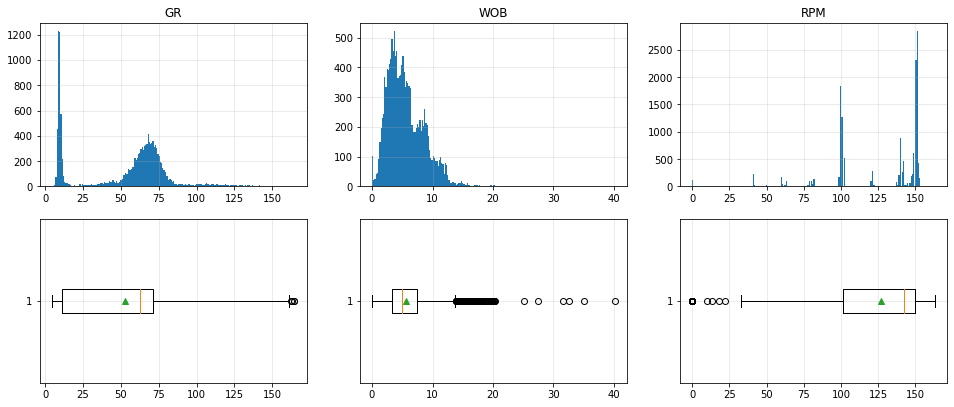

In [5]:
# PLOT PANEL EJEMPLO

fig,ax =plt.subplots(figsize=(14,5),nrows=2,ncols=3)
fig.subplots_adjust(hspace=0.2,left=0.05, right=0.95, bottom=0.05, top=1.05)

ax[0][0].title.set_text('GR')
ax[0][0].hist(df_shorter.GR,bins=200)
ax[1][0].boxplot(df_shorter.GR,vert=False,showmeans=True,showfliers=True)
ax[0][0].grid('True',alpha=0.3)
ax[1][0].grid('True',alpha=0.3)

ax[0][1].title.set_text('WOB')
ax[0][1].hist(df_shorter.WOB,bins=200)
ax[1][1].boxplot(df_shorter.WOB,vert=False,showmeans=True,showfliers=True)
ax[0][1].grid('True',alpha=0.3)
ax[1][1].grid('True',alpha=0.3)

ax[0][2].title.set_text('RPM')
ax[0][2].hist(df_shorter.RPM,bins=200)
ax[1][2].boxplot(df_shorter.RPM,vert=False,showmeans=True,showfliers=True)
ax[0][2].grid('True',alpha=0.3)
ax[1][2].grid('True',alpha=0.3)

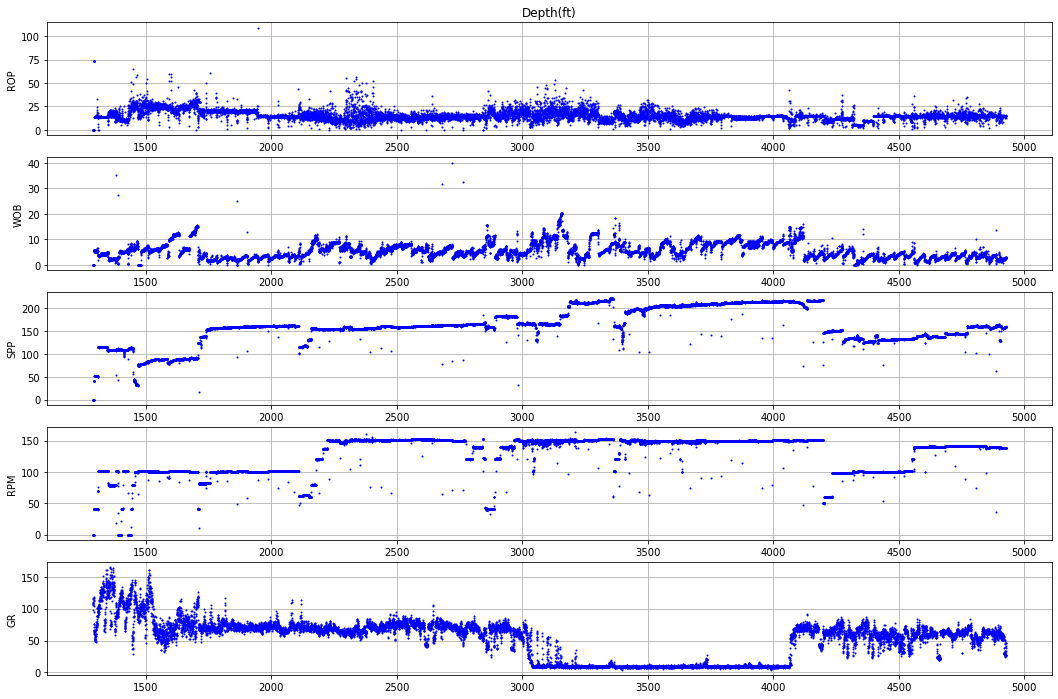

In [6]:
fig,ax=plt.subplots(figsize=(18,12),ncols=1,nrows=len(selected_columns))
for i in range(len(selected_columns)):
    ax[i].plot(df_shorter[selected_columns[i]],color='blue',ls=' ',marker='.',ms=2)
    ax[i].set_ylabel(df_shorter[selected_columns[i]].name)
    ax[0].set_title("Depth(ft)")
    ax[i].grid()

## Exploración de Datos

En este apartado nos proponemos inspeccionar los datos disponibles, entender de qué manera están representados, cómo se distribuyen y de qué manera se relacionan.

Además con la ayuda del heatmap de correlaciones comenzaremos a entender mejor de qué manera las distintas variables del procesos se relacionan entre sí, con el objetivo de las posibles conexiones que existentes entre las mismas.

Es interesante remarcar que en el dendograma del heat map SPP (stand pipe pressure) correlaciona negativamente con ROP (rate of penetration)

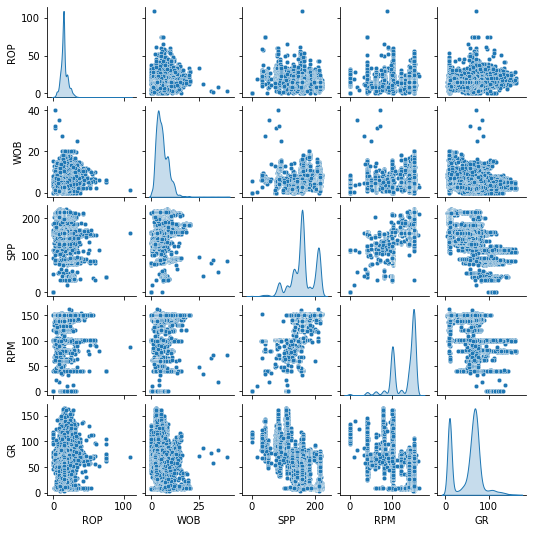

In [7]:
sns.pairplot(df_shorter,diag_kind='kde',plot_kws={'s':20},height=1.5)

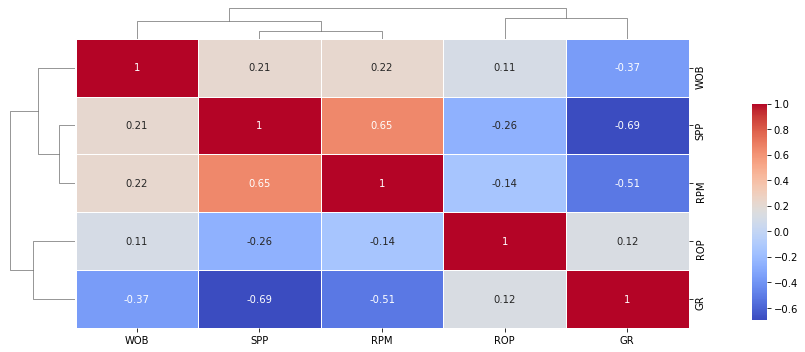

In [8]:
sns.clustermap(df_shorter.corr(),cmap='coolwarm',dendrogram_ratio=(.1,.1),cbar_pos=(1.05,.1,.02,.6),linewidths=1,figsize=(10,5),annot=True)

Text(0.5, 1.0, 'Indice de Correlación')

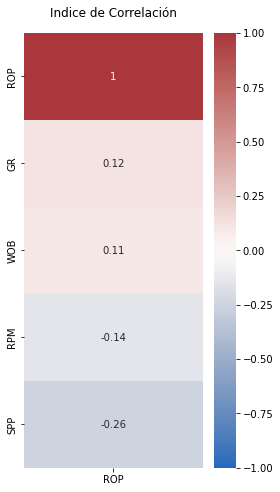

In [9]:
plt.figure(figsize=(4, 8))
heatmap = sns.heatmap(df_shorter.corr()[['ROP']].sort_values(by='ROP', ascending=False), vmin=-1, vmax=1, annot=True, cmap='vlag')
heatmap.set_title('Indice de Correlación', fontdict={'fontsize':12}, pad=16)

## Modelización

En esta etapa nos focalizaremos en el uso de *algoritmos supervisados* para la optimización de los parámetros de perforación,los cuales estarán orientados a maximizar ROP.

Previo a la implementación aplicaremos técnicas de clustering no supervisado para identificar (si existieran) posibles patrones ocultos, de manera de enriquecer el análisis general.

In [10]:
# ROP versus SPP

filtro_ROP=df_shorter[(df_shorter['ROP']<22.4) & (df_shorter['ROP']>9.8)] # Percentiles
#filtro_ROP=df_shorter[(df_shorter['ROP']<50) & (df_shorter['ROP']>1)] # Arbitrario

filtro_SPP=df_shorter[(df_shorter['SPP']<213) & (df_shorter['SPP']>110)] # Percentiles
#filtro_SPP=df_shorter[(df_shorter['SPP']<213) & (df_shorter['SPP']>110)] # Arbitrario

filtro=filtro_ROP.merge(filtro_SPP,how='inner')

df_total=filtro

#df_total=df_shorter
#df_total['ROP'].quantile(0.33)
#df_total['ROP'].quantile(0.66)
#from statistics import *
#quantiles(df_total['ROP'],n=3,method='inclusive')

df_total['Status']=pd.cut(df_total.ROP,[0,13.8,15.4,np.inf],labels=['low ROP','medium ROP','high ROP'])

data_y=df_total['ROP']
label_y='ROP'
data_x=df_total['SPP']
label_x='SPP'

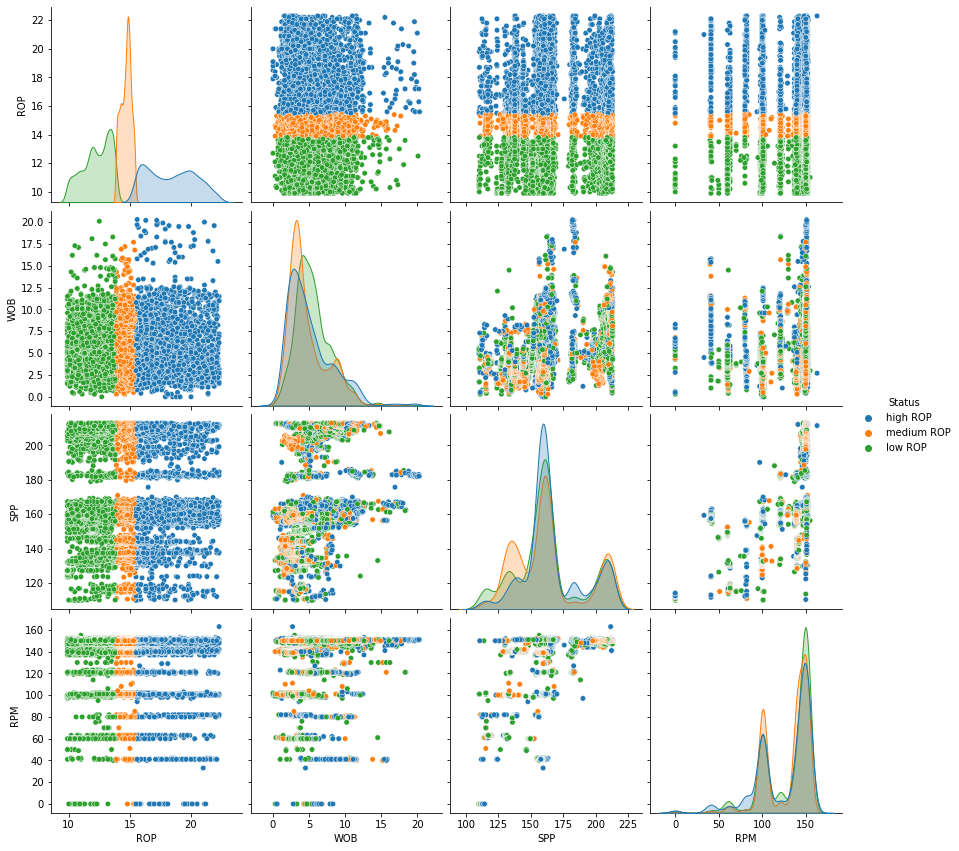

In [11]:
sns.pairplot(df_total,vars=['ROP','WOB','SPP','RPM'],diag_kind='kde',hue='Status',hue_order = ['high ROP','medium ROP','low ROP'],height=3,plot_kws={'s':30})

<AxesSubplot:xlabel='SPP', ylabel='ROP'>

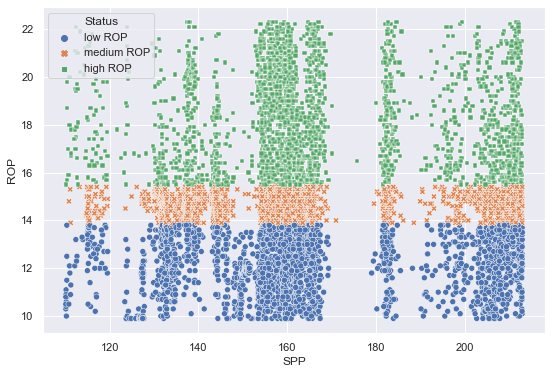

In [12]:
sns.set(rc={'figure.figsize':(9,6)})
sns.scatterplot(data=df_total, x='SPP', y='ROP', hue='Status',style='Status')

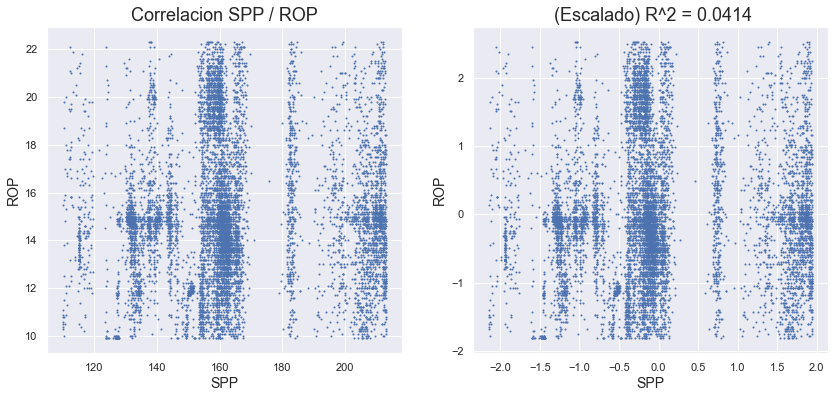

In [13]:
arr = pd.concat([data_x,data_y],axis=1).dropna().to_numpy()
arr_esc = StandardScaler().fit_transform(arr)

fig, ax = plt.subplots(figsize=(14,6), ncols=2)
r2 = data_x.corr(data_y).round(4)

titulo = 'Correlacion ' + data_x.name + ' / ' + data_y.name
ax[0].scatter(arr[:,0],arr[:,1], s=1) #scatter(x,y, s=1)
ax[0].set_title(titulo, fontsize=18)
ax[0].set_xlabel(data_x.name, fontsize=14)
ax[0].set_ylabel(data_y.name, fontsize=14)

titulo  = ' (Escalado) R^2 = ' + str(r2)
ax[1].scatter(arr_esc[:,0],arr_esc[:,1], s=1)
ax[1].set_title(titulo, fontsize=18)
ax[1].set_xlabel(data_x.name, fontsize=14)
ax[1].set_ylabel(data_y.name, fontsize=14)

plt.show()

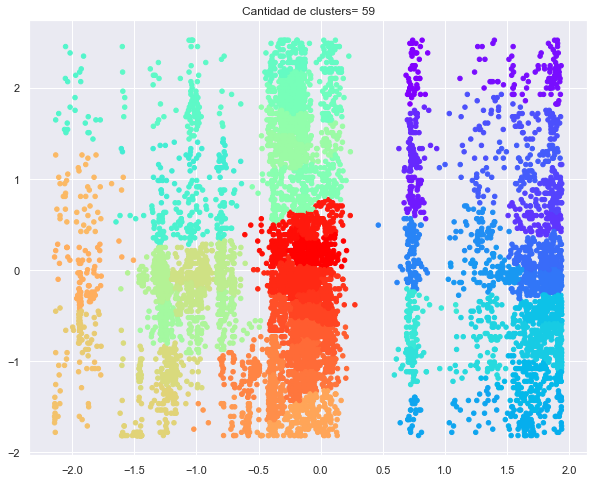

In [14]:
agrupados = linkage(arr_esc, 'ward', metric='euclidean') # single - complete - average - centroid - ward 
clusters = fcluster(agrupados, t=3, criterion='distance')
fig, ax = plt.subplots(figsize=(10,8), nrows=1)
ax.scatter(arr_esc[:,0],arr_esc[:,1], s=20, c=clusters,cmap='rainbow')
ax.set_title('Cantidad de clusters= '+ np.array2string(clusters.max()), fontsize=12)
plt.show()

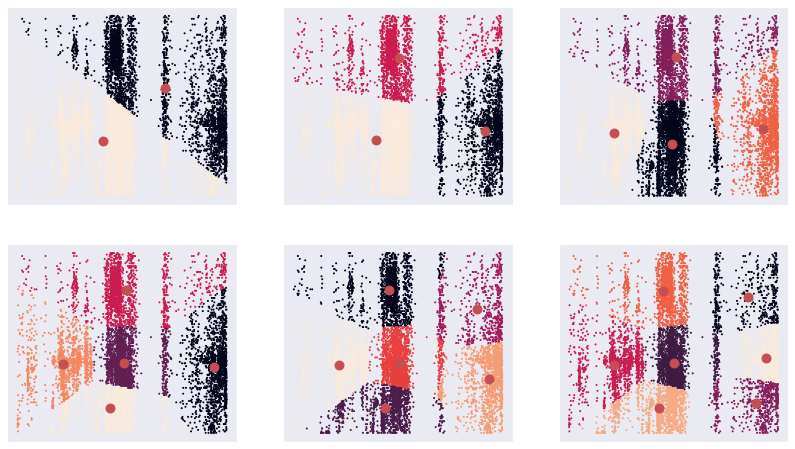

In [15]:
filas = 2
columnas = 3
fig, ax = plt.subplots(figsize=(14,8), nrows=filas, ncols=columnas)

for i in range (filas*columnas):
    col = i % columnas
    row = i // columnas
    modelo = KMeans(n_clusters = i+2)
    y_means = modelo.fit_predict(arr_esc)
    centroides = modelo.cluster_centers_
    ax[row][col].scatter(arr_esc[:,0], arr_esc[:,1], s=1, c=y_means)
    ax[row][col].scatter(centroides[:,0], centroides[:,1], s=80, color='r')
    ax[row][col].axes.xaxis.set_visible(False)
    ax[row][col].axes.yaxis.set_visible(False)
    #ax[row][col].text(s = 'n='+str(i+2), fontsize=20, y=0, x=6)

plt.show()

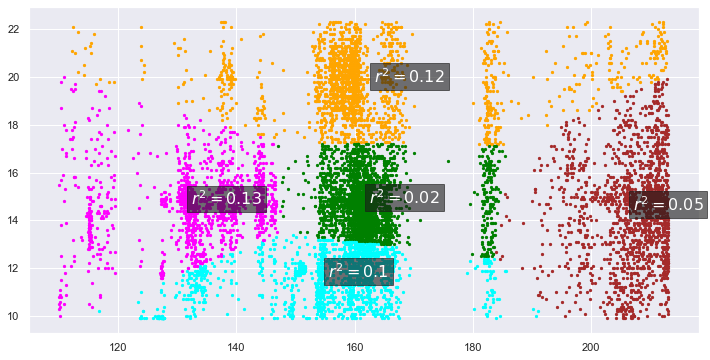

In [16]:
n=5
#r2 = data_x.corr(data_y).round(4)
arr = pd.concat([data_x,data_y],axis=1).dropna()
arr_esc = StandardScaler().fit_transform(arr)
arr=arr.reset_index()
arr.rename(columns={'index':'Depth'},inplace=True)

modelo = KMeans(n_clusters = n).fit(arr_esc)
y_means = modelo.fit_predict(arr_esc)
centroides = modelo.cluster_centers_ 

clustersList = list(y_means)
for i in range(len(arr)):
    arr.loc[i,'cluster'] = clustersList.pop()

colores= ["orange","green","brown","cyan","magenta","blue","red","yellow","lightgreen","pink"]  
plt.figure(figsize=(12,6))

for c in range(n):
        
    df_total = arr.loc[arr.cluster == c]
    co = round(df_total[label_x].corr(df_total[label_y]),2)

    plt.scatter(arr.loc[y_means == c][label_x],arr.loc[y_means == c][label_y],s=5, color=colores[c], cmap='rainbow')
            
    coords = (arr.loc[y_means==c][label_x].mean(), arr.loc[y_means==c][label_y].mean())
    t = plt.gca().annotate(f"$ r^2 = {co} $".format('g'), coords, fontsize=16, c="w")
    t.set_bbox(dict(facecolor='k', alpha=0.6, edgecolor='k'))


In [17]:
# ROP versus RPM
filtro_ROP=df_shorter[(df_shorter['ROP']<22.4) & (df_shorter['ROP']>9.8)] # Percentiles
#filtro_ROP=df_shorter[(df_shorter['ROP']<50) & (df_shorter['ROP']>1)] # Arbitrario
filtro_RPM=df_shorter[(df_shorter['RPM']<151) & (df_shorter['RPM']>99)] # Percentiles
#filtro_RPM=df_shorter[(df_shorter['RPM']<151) & (df_shorter['RPM']>99)] # Arbitrario
filtro=filtro_ROP.merge(filtro_RPM,how='inner')
df_total=filtro
data_y=df_total['ROP']
label_y='ROP'
data_x=df_total['RPM']
label_x='RPM'

# ROP versus SPP
#filtro_ROP=df_shorter[(df_shorter['ROP']<22.4) & (df_shorter['ROP']>9.8)]
#filtro_SPP=df_shorter[(df_shorter['SPP']<213) & (df_shorter['SPP']>110)]
#filtro=filtro_ROP.merge(filtro_SPP,how='inner')
#df_total=filtro
#data_y=df_total['ROP']
#label_y='ROP'
#data_x=df_total['SPP']
#label_x='SPP'

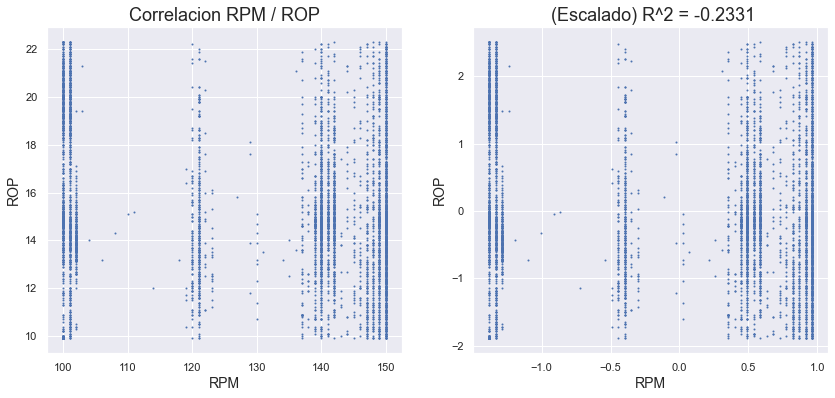

In [18]:
arr = pd.concat([data_x,data_y],axis=1).dropna().to_numpy()
arr_esc = StandardScaler().fit_transform(arr)

fig, ax = plt.subplots(figsize=(14,6), ncols=2)
r2 = data_x.corr(data_y).round(4)

titulo = 'Correlacion ' + data_x.name + ' / ' + data_y.name
ax[0].scatter(arr[:,0],arr[:,1], s=1) #scatter(x,y, s=1)
ax[0].set_title(titulo, fontsize=18)
ax[0].set_xlabel(data_x.name, fontsize=14)
ax[0].set_ylabel(data_y.name, fontsize=14)

titulo  = ' (Escalado) R^2 = ' + str(r2)
ax[1].scatter(arr_esc[:,0],arr_esc[:,1], s=1)
ax[1].set_title(titulo, fontsize=18)
ax[1].set_xlabel(data_x.name, fontsize=14)
ax[1].set_ylabel(data_y.name, fontsize=14)

plt.show()

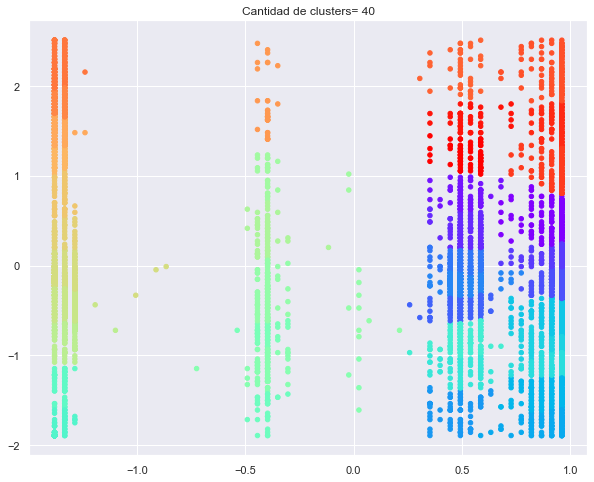

In [19]:
agrupados = linkage(arr_esc, 'ward', metric='euclidean') # single - complete - average - centroid - ward 
clusters = fcluster(agrupados, t=3, criterion='distance')
fig, ax = plt.subplots(figsize=(10,8), nrows=1)
ax.scatter(arr_esc[:,0],arr_esc[:,1], s=20, c=clusters,cmap='rainbow')
ax.set_title('Cantidad de clusters= '+ np.array2string(clusters.max()), fontsize=12)
plt.show()

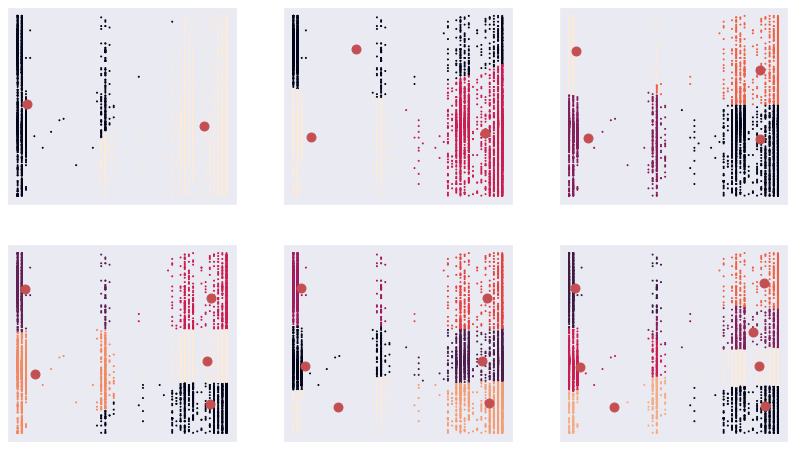

In [20]:
filas = 2
columnas = 3
fig, ax = plt.subplots(figsize=(14,8), nrows=filas, ncols=columnas)

for i in range (filas*columnas):
    col = i % columnas
    row = i // columnas
    modelo = KMeans(n_clusters = i+2)
    y_means = modelo.fit_predict(arr_esc)
    centroides = modelo.cluster_centers_
    ax[row][col].scatter(arr_esc[:,0], arr_esc[:,1], s=1, c=y_means)
    ax[row][col].scatter(centroides[:,0], centroides[:,1], s=80, color='r')
    ax[row][col].axes.xaxis.set_visible(False)
    ax[row][col].axes.yaxis.set_visible(False)
    #ax[row][col].text(s = 'n='+str(i+2), fontsize=20, y=0, x=6)

plt.show()

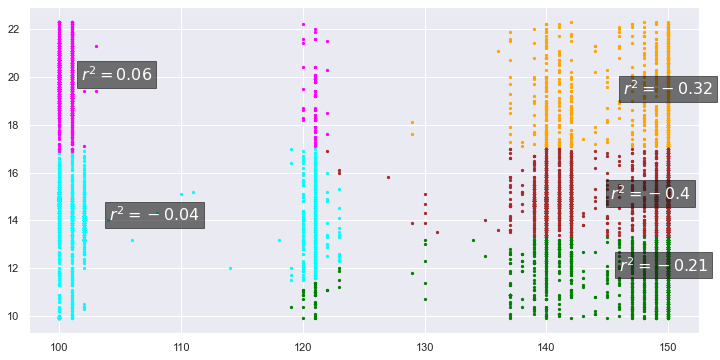

In [21]:
n=5
#r2 = data_x.corr(data_y).round(4)
arr = pd.concat([data_x,data_y],axis=1).dropna()
arr_esc = StandardScaler().fit_transform(arr)
arr=arr.reset_index()
arr.rename(columns={'index':'Depth'},inplace=True)

modelo = KMeans(n_clusters = n).fit(arr_esc)
y_means = modelo.fit_predict(arr_esc)
centroides = modelo.cluster_centers_ 

clustersList = list(y_means)
for i in range(len(arr)):
    arr.loc[i,'cluster'] = clustersList.pop()

colores= ["orange","green","brown","cyan","magenta","blue","red","yellow","lightgreen","pink"]  
plt.figure(figsize=(12,6))

for c in range(n):
        
    df_total = arr.loc[arr.cluster == c]
    co = round(df_total[label_x].corr(df_total[label_y]),2)

    plt.scatter(arr.loc[y_means == c][label_x],arr.loc[y_means == c][label_y],s=5, color=colores[c], cmap='rainbow')
            
    coords = (arr.loc[y_means==c][label_x].mean(), arr.loc[y_means==c][label_y].mean())
    t = plt.gca().annotate(f"$ r^2 = {co} $".format('g'), coords, fontsize=16, c="w")
    t.set_bbox(dict(facecolor='k', alpha=0.6, edgecolor='k'))


Previo a la implementación del algoritmos supervisado, es importante recordar que todo proceso de datascience debe comprender:

1. Look at the big picture.
2. Get the data.
3. Discover and visualize the data to gain insights.
4. Prepare the data for Machine Learning algorithms.
5. Select a model and train it.
6. Fine-tune your model.
7. Present your solution.
8. Launch, monitor, and maintain your system.

Respecto al proceso de optimización, podemos mencionar que el máximo ROP podría ser alcanzado exigiendo al límite la capacidad del equipo y su conjunto, sin embargo podremos setear constraints a fin de replicar las condiciones operativas lo más real posible.

La optimización del ROP será en función de la formación a perforar, para esto podemos podemos asumir:

* indexo por depth, asumiendo que depth es representativo de la formación (alternativa implementada)
* indexo por K means detectado sobre cada formación, y a partir de ahí conglomero.
* indexo por GR o cambios en el mismo.

In [112]:
X=df_shorter.iloc[:,1:4] # Selecciono WOB-SPP-RPM
y=df_shorter.iloc[:,0] # Selecciono ROP
#sc_X = StandardScaler()
#sc_y = StandardScaler()
#X = sc_X.fit_transform(X)
#y = sc_y.fit_transform(y)

# Se utiliza Support Vector Regresion - A fines ilustrativos no se optimizan los hiperparámetros

regressor = SVR(kernel='rbf') # C=1e3 , gamma=0.1
regressor.fit(X,y) # Fiteo todo el set de datos

SVR()

In [82]:
# Definimos intervalos para modelar en base a la lectura de GR
intervalo1=df_shorter.loc[1800:2800,:]
intervalo2=df_shorter.loc[3300:4000,:]
intervalo3=df_shorter.loc[4200:4900,:]

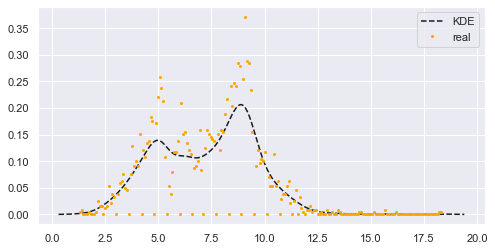

In [107]:
# Simulación del intervalo1
intervalo=intervalo3

# Evalúo modelar WOB para ser utilizado en el proceso de simulación
x_eval=np.linspace(min(intervalo2.WOB)-1,max(intervalo2.WOB)+1,len(intervalo2.WOB))
fig,ax=plt.subplots(figsize=(8,4))
kde=stats.gaussian_kde(intervalo2.WOB)
ax.plot(x_eval,kde(x_eval),'k--',label='KDE')
count,division=np.histogram(intervalo2.WOB,density=True,bins=200)
ax.plot(division[:-1],count,lw=2,color='orange',label='real',ls='',marker='.',ms=4)
ax.legend()

In [108]:
rango_RPM=[100,150]
rango_SPP=[100,150,200]
lista_RPM, lista_SPP,lista_WOB,lista_ROP=[],[],[],[]

kde=stats.gaussian_kde(intervalo.WOB)

for i in rango_RPM:
    for j in rango_SPP:
        for k in range(1000): # 1000 simulaciones
            WOB_simulado=kde.resample(size=1)
            X_simulado=np.array([WOB_simulado,j,i],ndmin=2,dtype=float)
            ROP_simulado=regressor.predict(X_simulado)
            lista_RPM.append(i)
            lista_SPP.append(j)
            lista_WOB.append(WOB_simulado[0])
            lista_ROP.append(ROP_simulado)

df_RPM=pd.DataFrame(lista_RPM,columns=['RPM'])
df_SPP=pd.DataFrame(lista_SPP,columns=['SPP'])
df_WOB=pd.DataFrame(lista_WOB,columns=['WOB'])
df_ROP=pd.DataFrame(lista_ROP,columns=['ROP'])
df_results=pd.concat([df_RPM,df_SPP,df_WOB,df_ROP],axis=1)
#df_results
df_results.sort_values('ROP',ascending=False).head()


,RPM,SPP,WOB,ROP
3642,150,100,12.903642,20.674791
3160,150,100,8.246995,20.413617
3967,150,100,8.030041,20.401109
3556,150,100,7.813295,20.388585
3791,150,100,7.645555,20.378873


In [109]:
agrupados=df_results.ROP.groupby([df_results.RPM,df_results.SPP])
print('ROP mean agrupado por RPM y SPP')
print(agrupados.mean())

ROP mean agrupado por RPM y SPP
RPM  SPP
100  100    18.909778
     150    14.352976
     200    17.428553
150  100    20.121373
     150    14.323100
     200    14.802950
Name: ROP, dtype: float64


In [110]:
# Inspeccionando al agrupamiento de ROP se observa su mayor valor en RPM=150 y SPP=100
mayor_ROP=df_results[(df_results['RPM']==150) & (df_results['SPP']==100)]

Text(0.5, 0, 'Depth (ft)')

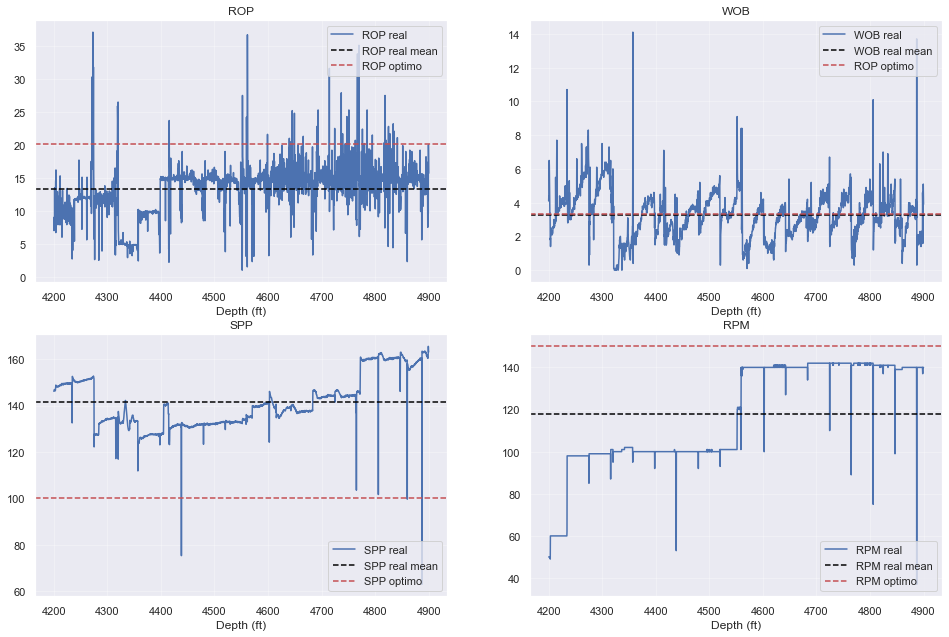

In [111]:

fig,ax =plt.subplots(figsize=(14,8),nrows=2,ncols=2)
fig.subplots_adjust(hspace=0.2,left=0.05, right=0.95, bottom=0.05, top=1.05)

ax[0][0].title.set_text('ROP')
ax[0][0].get_yaxis().set_major_formatter(mpl.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
ax[0][0].grid('True',alpha=0.3)
ax[0][0].plot(intervalo.ROP,'b-',label='ROP real ')
ax[0][0].axhline(intervalo.ROP.mean(),ls='--',color='black',label='ROP real mean')
ax[0][0].axhline(mayor_ROP.ROP.mean(),ls='--',color='r',label='ROP optimo')
ax[0][0].legend(loc='upper right')
ax[0][0].set_xlabel('Depth (ft)')

ax[0][1].title.set_text('WOB')
ax[0][1].get_yaxis().set_major_formatter(mpl.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
ax[0][1].grid('True',alpha=0.3)
ax[0][1].plot(intervalo.WOB,'b-',label='WOB real')
ax[0][1].axhline(intervalo.WOB.mean(),ls='--',color='black',label='WOB real mean')
ax[0][1].axhline(mayor_ROP.WOB.mean(),ls='--',color='r',label='ROP optimo')
ax[0][1].legend(loc='upper right')
ax[0][1].set_xlabel('Depth (ft)')

ax[1][0].title.set_text('SPP')
ax[1][0].get_yaxis().set_major_formatter(mpl.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
ax[1][0].grid('True',alpha=0.3)
ax[1][0].plot(intervalo.SPP,'b-',label='SPP real')
ax[1][0].axhline(intervalo.SPP.mean(),ls='--',color='black',label='SPP real mean')
ax[1][0].axhline(mayor_ROP.SPP.mean(),ls='--',color='r',label='SPP optimo')
ax[1][0].legend(loc='lower right')
ax[1][0].set_xlabel('Depth (ft)')

ax[1][1].title.set_text('RPM')
ax[1][1].get_yaxis().set_major_formatter(mpl.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
ax[1][1].grid('True',alpha=0.3)
ax[1][1].plot(intervalo.RPM,'b-',label='RPM real')
ax[1][1].axhline(intervalo.RPM.mean(),ls='--',color='black',label='RPM real mean')
ax[1][1].axhline(mayor_ROP.RPM.mean(),ls='--',color='r',label='RPM optimo')
ax[1][1].legend(loc='lower right')
ax[1][1].set_xlabel('Depth (ft)')

## Conclusiones

Lo interesante de resolver el problema de optimización es que nos permite generar escenarios operativos alternativos, situación que en el experimento real (en campo) no se podría realizar (sesgos, cultura, restricciones, ...), y comprobar/validar cómo se comportaría el sistema en su conjunto.

Para los tres intervalos analizados, resultó ser:

* Intervalo 1800-2800 ft: ROP optimizado varía +15 % (20 ft/ht), esto se lograr reduciendo el SPP de 160 a 100 e incrementando los RPM de 130 a 150.

* Intervalo 3300-4000 ft: ROP optimizado varía +40 % (20 ft/ht), esto se lograr reduciendo el SPP de 2000 a 100 (RPM es constante en 150).

* Intervalo 4200-4900 ft: ROP optimizado varía +40 % (20 ft/ht), esto se lograr reduciendo el SPP de 140 a 100 e incrementando los RPM de 120 a 150.

En líneas generales para los tres intervalos so observa que una reducción del SPP (mantener en valores de 100) mejoraría las performance del ROP; y en menor medida un incremento del RPM (régimenes de operación de 150 RPM aproximadamante)

Los valores WOB (weight on bit) no varían desde del caso real al simulado ya que al ser generados con la misma función distribución, el valor mean es el mismo.

A modo de comentario final, el ejercicio es una implementación simplificada del pipeline de datascience, cuyo objetivo es ilustar las bondades de dicho análisis.

***
### ANEXO

*Antecedentes*

* SPE 175748 (2015): improve ROP and identify ILT 

* SPE 181382 (2016): improve ROP

* jngse.2017.02.019 (2017): improve ROP

* petrol.2017.06.039 (2017): improve ROP

* SAS: improve ROP 

* Sridharan-Suresh Kumar (2020): improve ROP

* Drilling stuck pipe classifcation and mitigation in the Gulf of Suez oil felds using artifcial intelligence (2020)

* Machine learning algorithm for prediction of stuck pipe incidents using statistical data (2021)

* Use of Machine Learning and Data Analytics to Detect Downhole Abnormalities While Drilling Horizontal Wells (2021)